In [189]:
import pandas as pd
import pickle
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [138]:
df_out = pd.read_csv ('data/df_out.csv')
print (f"Размерность датасета {df_out.shape}")
print (f"Первые 5 строк датасета")
df_out.head(5)

Размерность датасета (10000, 20)
Первые 5 строк датасета


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


## Data Preparation

#### Data Cleaning

Выясняем в каких столбцах пропущены значения и сразу выводим процент пропущенных данных по столбцам

In [139]:
print (f"Процент пропущенных значений по столбцам \n {((df_out.isna().sum() / len(df_out)) * 100).sort_values()}")

Процент пропущенных значений по столбцам 
 id                0.00
state             0.00
price_category    0.00
manufacturer      0.00
odometer          0.00
region_url        0.00
region            0.00
url               0.00
price             0.00
image_url         0.02
description       0.02
posting_date      0.02
date              0.02
year              0.36
transmission      0.45
fuel              0.63
lat               0.98
long              0.98
model             1.28
title_status      1.66
dtype: float64


Для наглядности можно посмотреть матрицу пропусков

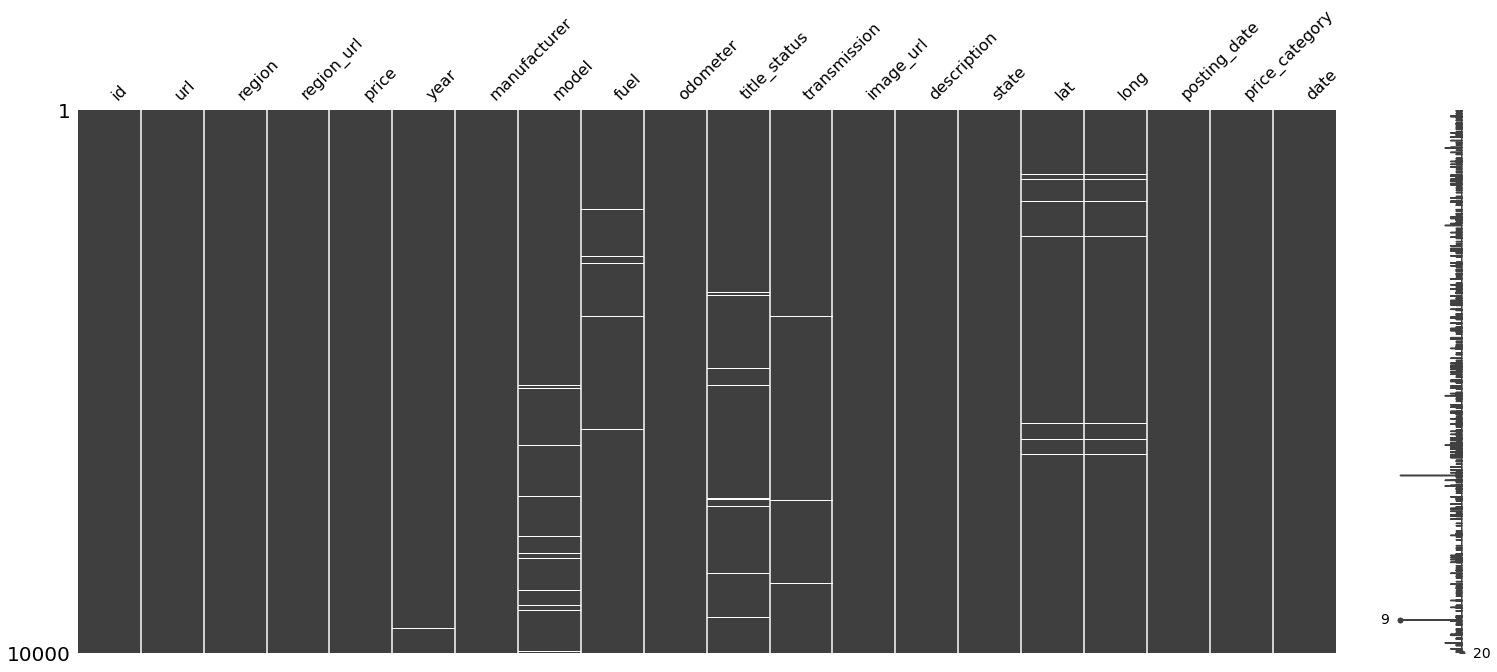

In [140]:
msno.matrix(df_out);

In [141]:
print('Количество полностью заполненных объектов из всей выборки:', len(df_out.dropna()))
print('Процент полностью заполненных объектов из всей выборки:', round(len(df_out.dropna()) / len(df_out) * 100, 2))

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 95.07


С учётом, что отсутсвует 4.93% данных это вполне допустимая потеря. Просто удалим неполные строки

In [142]:
df_out = df_out.dropna ()
df_out.shape

(9507, 20)

In [143]:
print('Количество полностью заполненных объектов из всей выборки:', len(df_out.dropna()))
print('Процент полностью заполненных объектов из всей выборки:', round(len(df_out.dropna()) / len(df_out) * 100, 2))

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 100.0


Преводим типы данных

In [144]:
#преобразую дату в соответствующий тип данных
df_out['date'] = pd.to_datetime(df_out.date, utc=True)
#удаляю дублирующий столбец с датой
df_out = df_out.drop(['posting_date'], axis=1)
#преобразую год из вещественного типа в целочисленный
df_out.year = df_out.year.astype (int)
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9507 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9507 non-null   int64              
 1   url             9507 non-null   object             
 2   region          9507 non-null   object             
 3   region_url      9507 non-null   object             
 4   price           9507 non-null   int64              
 5   year            9507 non-null   int32              
 6   manufacturer    9507 non-null   object             
 7   model           9507 non-null   object             
 8   fuel            9507 non-null   object             
 9   odometer        9507 non-null   int64              
 10  title_status    9507 non-null   object             
 11  transmission    9507 non-null   object             
 12  image_url       9507 non-null   object             
 13  description     9507 non-null   o

Проверяем числовые данные на наличие выбросов

In [145]:
#Функция для определения границы нормально распределённых данных
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries

In [146]:
def calculate_stats (data):
    f = data.describe().apply(lambda x: f"{x:0.3f}")
    print (f"Простые статистики \n {f}")
    fig, ax = plt.subplots (figsize=(8, 8))
    ax.boxplot(data)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    df_out_boundaries = calculate_outliers(data)
    print (f"\n Интерквартильный размах {df_out_boundaries}")
    is_outliers = (data < df_out_boundaries[0]) | (data > df_out_boundaries[1])
    print (f"\n Общее количество выбросов {is_outliers.sum ()}")


##### 1. Столбец Price

Простые статистики 
 count       9507.000
mean       19382.555
std        18328.500
min          500.000
25%         7836.500
50%        15900.000
75%        27990.000
max      1000000.000
Name: price, dtype: object

 Интерквартильный размах (-22393.75, 58220.25)

 Общее количество выбросов 181


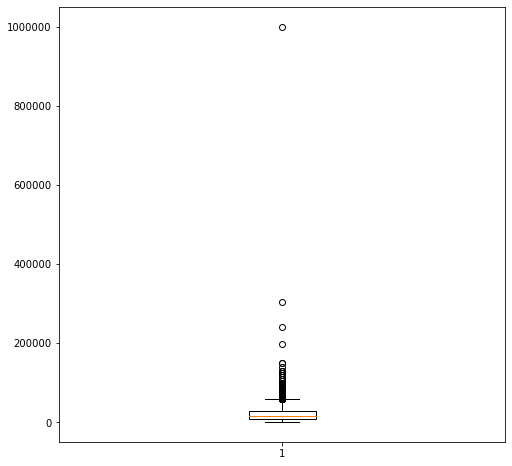

In [147]:
calculate_stats(df_out.price)

Приведенные статистики и график показывают наличие 181 выброса. Заменяем их верхним значением интерквартильного размаха

Простые статистики 
 count     9507.000
mean     18933.934
std      13604.639
min        500.000
25%       7836.500
50%      15900.000
75%      27990.000
max      58220.000
Name: price, dtype: object

 Интерквартильный размах (-22393.75, 58220.25)

 Общее количество выбросов 0


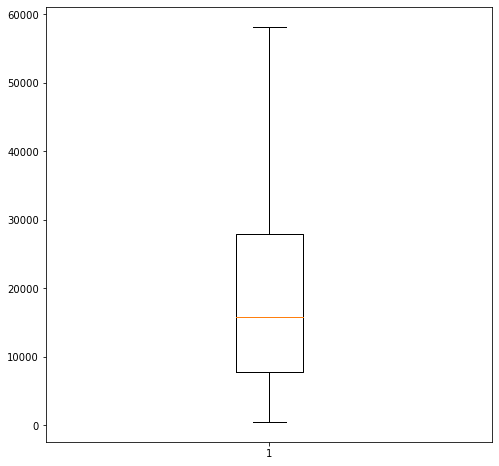

In [148]:
df_out_price_boundaries = calculate_outliers(df_out.price)
is_outliers_price = (df_out.price < df_out_price_boundaries[0]) | (df_out.price > df_out_price_boundaries[1])
df_out.loc[is_outliers_price, 'price'] = int (df_out_price_boundaries[1])
calculate_stats(df_out.price)

##### 2. Столбец Year

Простые статистики 
 count    9507.000
mean     2011.024
std         9.467
min      1915.000
25%      2008.000
50%      2013.000
75%      2017.000
max      2022.000
Name: year, dtype: object

 Интерквартильный размах (1994.5, 2030.5)

 Общее количество выбросов 362


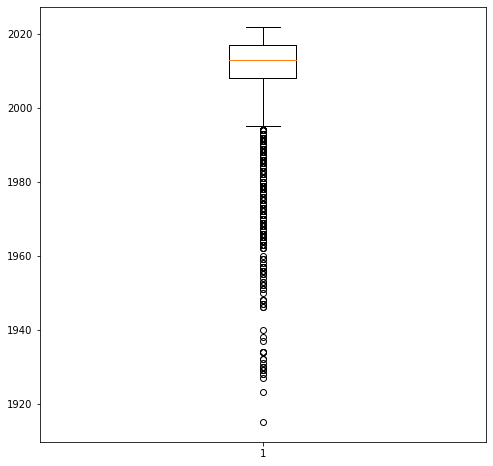

In [149]:
calculate_stats(df_out.year)

Приведенные статистики и график показывают наличие 362 выбросов. Заменяем их верхним значением интерквартильного размаха

362
Простые статистики 
 count    9507.000
mean     2011.754
std         6.389
min      1995.000
25%      2008.000
50%      2013.000
75%      2017.000
max      2022.000
Name: year, dtype: object

 Интерквартильный размах (1994.5, 2030.5)

 Общее количество выбросов 0


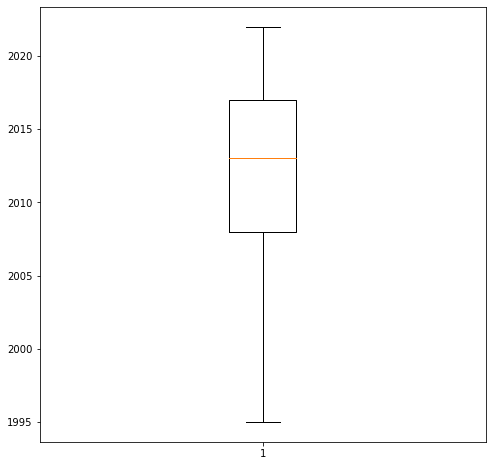

In [150]:
df_out_year_boundaries = calculate_outliers(df_out.year)
is_outliers_year = (df_out.year < df_out_year_boundaries[0]) | (df_out.year > df_out_year_boundaries[1])
print (is_outliers_year.sum())
df_out.loc[is_outliers_year, 'year'] = int (df_out_year_boundaries[0])+1
calculate_stats(df_out.year)

##### 3. Столбец Odometer

Простые статистики 
 count      9507.000
mean      93570.815
std       63242.740
min           0.000
25%       39244.000
50%       89000.000
75%      137054.500
max      283466.000
Name: odometer, dtype: object

 Интерквартильный размах (-107471.75, 283770.25)

 Общее количество выбросов 0


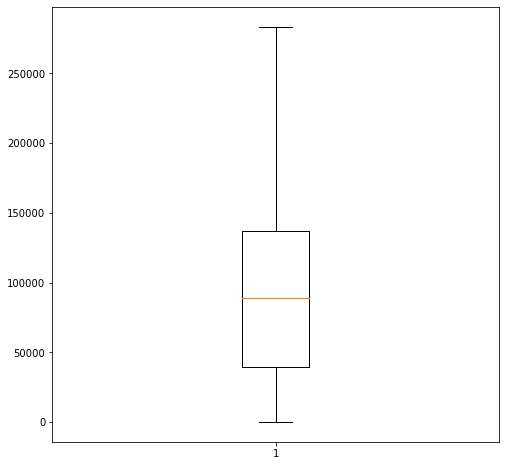

In [151]:
calculate_stats(df_out.odometer)

##### 4. Столбец Lat

Простые статистики 
 count    9507.000
mean       38.593
std         5.837
min       -67.144
25%        34.875
50%        39.290
75%        42.417
max        64.948
Name: lat, dtype: object

 Интерквартильный размах (23.561381250000004, 53.73085124999999)

 Общее количество выбросов 134


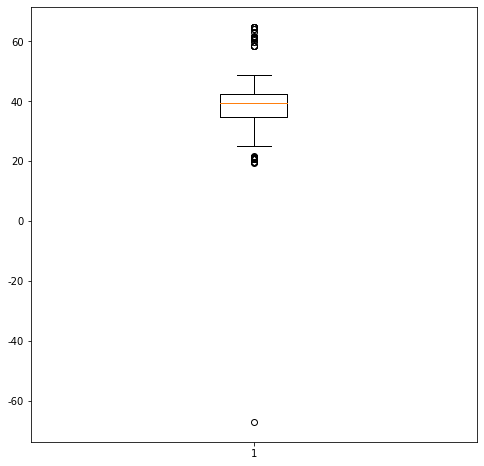

In [152]:
calculate_stats(df_out.lat)

Приведенные статистики и график показывают наличие 134 выброса. Заменяем их верхним значением интерквартильного размаха

Простые статистики 
 count    9507.000
mean       38.277
std         5.456
min        23.561
25%        34.556
50%        39.162
75%        42.316
max        48.937
Name: lat, dtype: object

 Интерквартильный размах (22.916755749999986, 53.95562975000001)

 Общее количество выбросов 0


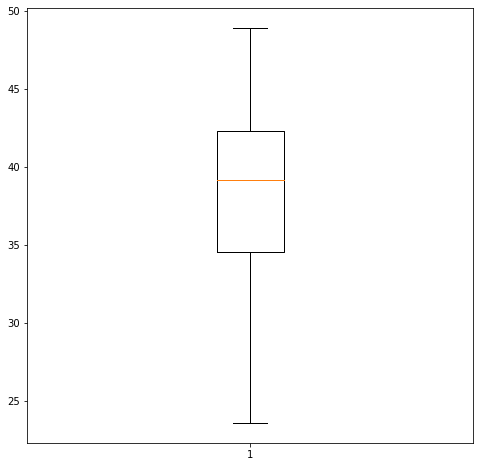

In [153]:
df_out_lat_boundaries = calculate_outliers(df_out.lat)
is_outliers_lat = (df_out.lat < df_out_lat_boundaries[0]) | (df_out.lat > df_out_lat_boundaries[1])
df_out.loc[is_outliers_lat, 'lat'] = df_out_lat_boundaries[0]
calculate_stats(df_out.lat)

##### 5. Столбец Long

Простые статистики 
 count    9507.000
mean      -93.958
std        18.029
min      -158.069
25%      -107.979
50%       -87.960
75%       -80.719
max       173.886
Name: long, dtype: object

 Интерквартильный размах (-148.86772674999997, -39.82982475000004)

 Общее количество выбросов 121


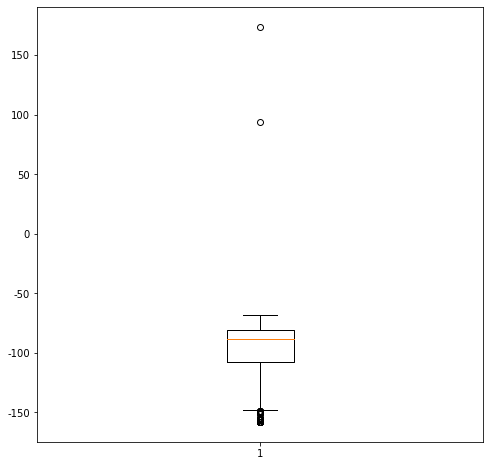

In [154]:
calculate_stats(df_out.long)

Приведенные статистики и график показывают наличие 121 выброса. Заменяем их верхним значением интерквартильного размаха

Простые статистики 
 count    9507.000
mean      -93.967
std        17.566
min      -148.868
25%      -108.164
50%       -87.968
75%       -80.725
max       -68.508
Name: long, dtype: object

 Интерквартильный размах (-149.32258674999997, -39.56568875000001)

 Общее количество выбросов 0


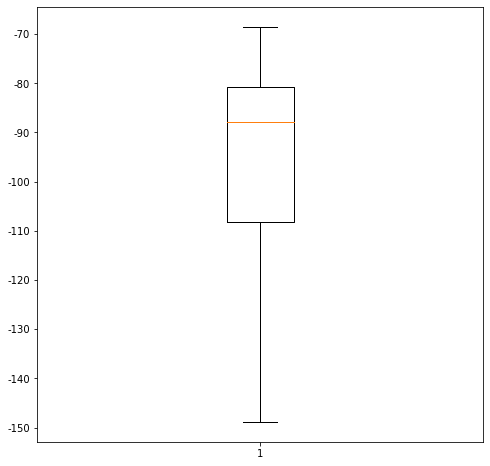

In [155]:
df_out_long_boundaries = calculate_outliers(df_out.long)
is_outliers_long = (df_out.long < df_out_long_boundaries[0]) | (df_out.long > df_out_long_boundaries[1])
df_out.loc[is_outliers_long, 'long'] = df_out_long_boundaries[0]
calculate_stats(df_out.long)

#### Data Visualization

In [156]:
df_out.corr()

,id,price,year,odometer,lat,long
id,1.000000,-0.095934,-0.102005,0.051181,-0.066517,-0.107925
price,-0.095934,1.000000,0.545923,-0.532728,-0.020326,-0.075663
year,-0.102005,0.545923,1.000000,-0.516999,-0.050752,0.005955
odometer,0.051181,-0.532728,-0.516999,1.000000,0.047294,0.003293
lat,-0.066517,-0.020326,-0.050752,0.047294,1.000000,0.025948
long,-0.107925,-0.075663,0.005955,0.003293,0.025948,1.000000


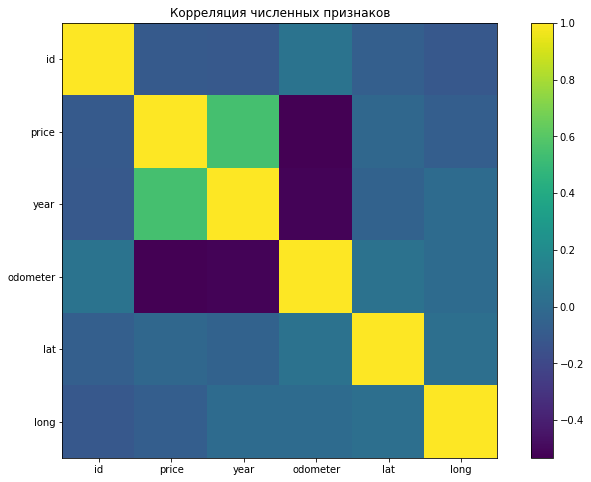

In [157]:
plt.figure(figsize=(12, 8))

columns = df_out.corr().columns.tolist()
plt.imshow(df_out.corr())

plt.title("Корреляция численных признаков")
plt.xticks(range(0, len(columns)), columns)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

Приведённая матрица и графика показывают достаточно низкую корреляцию между переменными. Выделяются чуть более высокими значеними price, odometer и year 

#### Feature Engineering

In [158]:
df_out.head(5)

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,high,2021-04-17 16:30:50+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,medium,2021-05-03 22:32:06+00:00
5,7303797340,https://knoxville.craigslist.org/ctd/d/knoxvil...,knoxville,https://knoxville.craigslist.org,14590,2012,bmw,1 series 128i coupe 2d,other,80465,clean,other,https://images.craigslist.org/00F0F_5UAXmOzC18...,Carvana is the safer way to buy a car During t...,tn,35.970000,-83.940000,medium,2021-04-08 19:10:56+00:00


##### 1. Генерируем дополнительные фичи

In [159]:
df_out_date = df_out.copy ()

In [160]:
df_out ['date_year'] = df_out_date.date.apply (lambda x: x.year).astype (int)
df_out ['date_month'] = df_out_date.date.apply (lambda x: x.month).astype (int)
df_out ['date_day'] = df_out_date.date.apply (lambda x: x.day).astype (int)
df_out

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,image_url,description,state,lat,long,price_category,date,date_year,date_month,date_day
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,high,2021-04-17 16:30:50+00:00,2021,4,17
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,high,2021-04-28 10:52:20+00:00,2021,4,28
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,medium,2021-04-17 14:08:57+00:00,2021,4,17
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,medium,2021-05-03 22:32:06+00:00,2021,5,3
5,7303797340,https://knoxville.craigslist.org/ctd/d/knoxvil...,knoxville,https://knoxville.craigslist.org,14590,2012,bmw,1 series 128i coupe 2d,other,80465,...,https://images.craigslist.org/00F0F_5UAXmOzC18...,Carvana is the safer way to buy a car During t...,tn,35.970000,-83.940000,medium,2021-04-08 19:10:56+00:00,2021,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7304876387,https://chautauqua.craigslist.org/ctd/d/falcon...,chautauqua,https://chautauqua.craigslist.org,4495,2002,toyota,rav4,gas,150000,...,https://images.craigslist.org/00n0n_aaEBqmzz5Z...,Transmission:Automatic Exterior Color:WHITE In...,ny,42.123900,-79.189500,low,2021-04-10 20:33:57+00:00,2021,4,10
9996,7316152972,https://binghamton.craigslist.org/ctd/d/roches...,binghamton,https://binghamton.craigslist.org,14495,2008,jeep,wrangler,gas,113573,...,https://images.craigslist.org/00000_9ZNVdXaiei...,2008 Jeep Wrangler X Offered by: R&L Auto -- ...,ny,43.216990,-77.755610,medium,2021-05-03 13:36:30+00:00,2021,5,3
9997,7310993818,https://salem.craigslist.org/ctd/d/salem-2011-...,salem,https://salem.craigslist.org,8995,2011,audi,a3 2.0t premium plus pzev,gas,150184,...,https://images.craigslist.org/00X0X_k5JiZDDyqM...,2011 Audi A3 2.0T Premium Plus PZEV Wagon2011 ...,or,44.925908,-122.982753,low,2021-04-22 19:14:01+00:00,2021,4,22
9998,7306637427,https://madison.craigslist.org/ctd/d/madison-2...,madison,https://madison.craigslist.org,31900,2015,porsche,cayenne,hybrid,61943,...,https://images.craigslist.org/00O0O_gBihGEQxYT...,"2015 Porsche Cayenne AWD 4dr S E-Hybrid - $31,...",wi,43.029559,-89.397796,high,2021-04-14 14:14:42+00:00,2021,4,14


##### 2.Закодируем категориальные переменные

Выведем категориальные переменные датасета и колличество уникальных значений в них

In [161]:
print (f"Категориальные переменные датасета и колличество уникальных значений в них:")
print (f"region - {len (df_out.region.unique())}")
print (f"manufacturer - {len (df_out.manufacturer.unique())}")
print (f"model - {len (df_out.model.unique())}")
print (f"fuel - {len (df_out.fuel.unique())}")
print (f"title_status - {len (df_out.title_status.unique())}")
print (f"transmission - {len (df_out.transmission.unique())}")
print (f"state - {len (df_out.state.unique())}")

Категориальные переменные датасета и колличество уникальных значений в них:
region - 393
manufacturer - 40
model - 3317
fuel - 5
title_status - 6
transmission - 3
state - 51


Попробуем уменьшить колличество уникальных значение region, model

In [162]:
df_out ['short_model'] = df_out.model.apply (lambda x: x.split (' ') [0])
df_out ['short_region'] = df_out.region.apply (lambda x: x.split (' / ')[0])
print (f"short_model - {len (df_out.short_model.unique())}")
print (f"short_region - {len (df_out.short_region.unique())}")

short_model - 964
short_region - 390


Вдальнейшем при кодировании категориальных переменных воспользуемся изменнённым столбцом short_model, т.к. в результате преобразования получили значительное изменение колличества уникальных значений. Изменённым столбцом пользоваться не буду, ввиду того что колличество уникальных значений уменьшилось всего на 3 единицы из 393.

In [163]:
df_out_ohe = df_out [['region', 'manufacturer', 'short_model','fuel', 'title_status', 'transmission', 'state']]
df_out_ohe

,region,manufacturer,short_model,fuel,title_status,transmission,state
0,chattanooga,ram,2500,diesel,clean,other,tn
2,reno / tahoe,volkswagen,golf,gas,clean,other,ca
3,fayetteville,toyota,rav4,gas,clean,automatic,nc
4,new york city,nissan,altima,gas,clean,automatic,ny
5,knoxville,bmw,1,other,clean,other,tn
...,...,...,...,...,...,...,...
9995,chautauqua,toyota,rav4,gas,clean,automatic,ny
9996,binghamton,jeep,wrangler,gas,clean,other,ny
9997,salem,audi,a3,gas,clean,automatic,or
9998,madison,porsche,cayenne,hybrid,clean,automatic,wi


In [164]:
ohe = OneHotEncoder(sparse=False)

In [165]:
ohe.fit(df_out_ohe)

OneHotEncoder(sparse=False)

In [166]:
df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
df_out.head (5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmente

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out [ohe.get_feature_names ()] = ohe.transform(df_out_ohe)
C:\Users\avche\AppData\Local\Temp\ipykernel_12512\2832591477.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,x6_sd,x6_tn,x6_tx,x6_ut,x6_va,x6_vt,x6_wa,x6_wi,x6_wv,x6_wy
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7303797340,https://knoxville.craigslist.org/ctd/d/knoxvil...,knoxville,https://knoxville.craigslist.org,14590,2012,bmw,1 series 128i coupe 2d,other,80465,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 3. Выполним нормализацию численных данных датасета

In [167]:
std = StandardScaler ()
std

StandardScaler()

In [168]:
std.fit(df_out[['price', 'year', 'odometer', 'lat', 'long', 'date_year','date_month', 'date_day']])

StandardScaler()

In [169]:
df_out[['std_scaled_price', 'std_scaled_year', 'std_scaled_odometer', 'std_scaled_lat', 'std_scaled_long', 'std_scaled_date_year','std_scaled_date_month', 'std_scaled_date_day']] = std.transform (df_out[['price', 'year', 'odometer', 'lat', 'long', 'date_year','date_month', 'date_day']])
df_out.head (1)

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,x6_wv,x6_wy,std_scaled_price,std_scaled_year,std_scaled_odometer,std_scaled_lat,std_scaled_long,std_scaled_date_year,std_scaled_date_month,std_scaled_date_day
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,0.0,2.650417,1.290761,-1.04569,-0.589607,0.496302,0.0,-0.616788,0.174183


Удалим столбцы которые не информативны для моделей машинного обучения

In [171]:
df_out = df_out.drop (['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 
                           'model', 'fuel', 'odometer', 'transmission', 'image_url', 'description', 
                           'state', 'lat', 'long', 'title_status','short_model', 'short_region', 'date', 'date_year','date_month', 'date_day'], axis=1)
df_out

,price_category,x0_SF bay area,x0_abilene,x0_akron / canton,x0_albany,x0_albuquerque,x0_altoona-johnstown,x0_amarillo,x0_ames,x0_anchorage / mat-su,...,x6_wv,x6_wy,std_scaled_price,std_scaled_year,std_scaled_odometer,std_scaled_lat,std_scaled_long,std_scaled_date_year,std_scaled_date_month,std_scaled_date_day
0,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.650417,1.290761,-1.045690,-0.589607,0.496302,0.0,-0.616788,0.174183
2,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.224358,0.821161,-1.257488,-0.824371,0.544021,0.0,-0.616788,1.258959
3,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.325930,0.195028,0.375085,-0.469372,0.871752,0.0,-0.616788,0.174183
4,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.210679,1.447294,-1.353125,0.435903,1.159008,0.0,1.621304,-1.206440
5,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.319315,0.038495,-0.207241,-0.422806,0.570883,0.0,-0.616788,-0.713361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.061380,-1.526837,0.892310,0.705184,0.841339,0.0,-0.616788,-0.516129
9996,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.326298,-0.587637,0.316293,0.905544,0.922973,0.0,1.621304,-1.206440
9997,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.730593,-0.118038,0.895220,1.218784,-1.651904,0.0,-0.616788,0.667263
9998,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.953112,0.508095,-0.500128,0.871189,0.260159,0.0,-0.616788,-0.121665


In [173]:
df_out.to_csv('data/df_out_upd.csv', index=False)

## Modeling

##### 1. Разделим выборку на тренировочную и тестовую

In [175]:
df_out_model = df_out.copy ()
x = df_out_model.drop(['price_category'], axis=1)
y = df_out_model['price_category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

##### 2. Обучим модель случайного леса (RandomForestClassifier)

In [176]:
clf_rfc = RandomForestClassifier ()
clf_rfc.fit (x_train, y_train)

RandomForestClassifier()

Проверим точность на тренировочной и тестовой выборке

In [181]:
predict_rfc = clf_rfc.predict (x_test)
predict_rfc_2 = clf_rfc.predict (x_train)
print (f"Точность на тестовой выборке равна: {accuracy_score(y_test, predict_rfc)}")
print (f"Точность на тренировочной выборке равна: {accuracy_score(y_train, predict_rfc_2)}")

Точность на тестовой выборке равна: 0.9919383105502979
Точность на тренировочной выборке равна: 1.0


##### 3. Обучим логистическую регрессию

In [182]:
clf_lr = LogisticRegression (C=2.2, penalty='l2', solver='newton-cg', class_weight='balanced', random_state=42, n_jobs=-1)
clf_lr.fit (x_train, y_train)

LogisticRegression(C=2.2, class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='newton-cg')

In [192]:
predict_lr = clf_lr.predict (x_test)
predict_lr_2 = clf_lr.predict (x_train)
print (f"Точность на тренировочной выборке равна: {accuracy_score(y_train, predict_lr_2)}")
print (f"Точность на тестовой выборке равна: {accuracy_score(y_test, predict_lr)}")


Точность на тренировочной выборке равна: 0.9987977156597535
Точность на тестовой выборке равна: 0.9754644234139502


##### 4. Обучим многослойный персептрон

In [185]:
mlp = MLPClassifier (random_state=42, max_iter=500)
mlp.fit (x_train, y_train)

MLPClassifier(max_iter=500, random_state=42)

In [186]:
predict_mlp = mlp.predict (x_test)
predict_mlp_2 = mlp.predict (x_train)
print (f"Точность на тестовой выборке равна: {accuracy_score(y_test, predict_mlp)}")
print (f"Точность на тренировочной выборке равна: {accuracy_score(y_train, predict_mlp_2)}")

Точность на тестовой выборке равна: 0.9362075008762706
Точность на тренировочной выборке равна: 1.0


##### 5. Выполним кросс-валидацию

In [198]:
df_out_model.shape

(9507, 1471)

###### Модель случайного леса

In [203]:
print (f"Результаты кросс-валидации: {cross_validate (clf_rfc, x, y, cv=5, scoring=('accuracy'))}")
cv_score_rfc = cross_val_score (clf_rfc, x, y, cv=5)
print (f"Среднее значение метрики равно {cv_score_rfc.mean ()}, стандартное отклонение равно {cv_score_rfc.std ()}")

Результаты кросс-валидации: {'fit_time': array([3.62306619, 3.62110138, 3.82000208, 3.70291424, 3.60190964]), 'score_time': array([0.06199884, 0.06198692, 0.0649972 , 0.06608248, 0.06100059]), 'test_score': array([0.99526814, 0.99526814, 0.99579169, 0.99579169, 0.99579169])}
Среднее значение метрики равно 0.9938993313055112, стандартное отклонение равно 0.0015095734767742713


Модель показывает незначительное изменение метрик по результатам кросс валидации. Можно сделать вывод, что переобучения не наблядается

###### Логистическая регрессия

In [201]:
print (f"Результаты кросс-валидации: {cross_validate (clf_lr, x, y, cv=5, scoring=('accuracy'))}")
cv_score_lr = cross_val_score (clf_lr, x, y, cv=5)
print (f"Среднее значение метрики равно {cv_score_lr.mean ()}, стандартное отклонение равно {cv_score_lr.std ()}")

Результаты кросс-валидации: {'fit_time': array([28.28152823, 26.95397353, 29.34550071, 28.22911215, 30.02206898]), 'score_time': array([0.01600027, 0.01491785, 0.01192904, 0.01293159, 0.0129981 ]), 'test_score': array([0.97634069, 0.97634069, 0.97527617, 0.97790637, 0.98158864])}
Среднее значение метрики равно 0.977490512215885, стандартное отклонение равно 0.002214273617782966


Модель показывает незначительное изменение метрик по результатам кросс валидации. Можно сделать вывод, что переобучения не наблядается

###### Многослойный персептрон

In [204]:
print (f"Результаты кросс-валидации: {cross_validate (mlp, x, y, cv=5, scoring=('accuracy'))}")
cv_score_mlp = cross_val_score (mlp, x, y, cv=5)
print (f"Среднее значение метрики равно {cv_score_mlp.mean ()}, стандартное отклонение равно {cv_score_mlp.std ()}")

Результаты кросс-валидации: {'fit_time': array([54.14709711, 67.27387094, 52.05962229, 59.93382645, 53.77901053]), 'score_time': array([0.02203655, 0.02299976, 0.01799941, 0.02199793, 0.02098989]), 'test_score': array([0.95268139, 0.94426919, 0.94950026, 0.9431878 , 0.94634403])}
Среднее значение метрики равно 0.9471965333426262, стандартное отклонение равно 0.0034858823013354016


Модель показывает незначительное изменение метрик по результатам кросс валидации. Можно сделать вывод, что переобучения не наблядается

## Results

По результатам обучения все модели показали, следующие результаты после кросс-валидации:
- Модель случайного леса: среднее значение метрики равно 0.9938993313055112, стандартное отклонение равно 0.0015095734767742713
- Логистическая регрессия: среднее значение метрики равно 0.977490512215885, стандартное отклонение равно 0.002214273617782966
- Многослойный персептрон: среднее значение метрики равно 0.9471965333426262, стандартное отклонение равно 0.0034858823013354016

Как видим отклонения незначительные, но чуть лучшие результаты показала модель случайного леса, кроме того её обучение проходит значительно быстрее остальных, в связи с этим в pickle передадим её.

In [205]:
with open ('data/model.pickle', 'wb') as file:
    pickle.dump (clf_rfc, file)